This notebook was used to explore some of the features and base performance of the original full data set

In [27]:
#imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot

It seems that after fixing a few of the intitial issues, Random Forrest and SVM are no longer making accurate predictions at all. Using the full data set may not
be a good idea.

In [47]:
data = pd.read_csv("Data/Final Dataset.csv")

In [29]:
df = data.copy().drop(columns=['Player','Team','Conference','Position','Division','Stars'])
df['Transfer_Portal'] = np.where(df['Transfer_Portal'].values == 'Yes', 1, 0)
df = df.fillna(0)
df.head()

,Season,PlayerId,Usage Overall,Usage Pass,Usage Rush,Usage FirstDown,Usage SecondDown,Usage ThirdDown,Usage StandardDowns,Usage PassingDowns,...,Team sacks,Team tacklesForLoss,Team thirdDownConversions,Team thirdDowns,Team totalYards,Team turnovers,Transfer_Portal,PositionId,TeamId,ConferenceId
0,2019,4240710,0.1587,0.0525,0.3056,0.1700,0.202,0.101,0.164,0.142,...,60,124,84,211,4946,22,0,0,0,0
1,2019,4036066,0.0228,0.0394,0.0024,0.0246,0.006,0.038,0.018,0.024,...,60,124,84,211,4946,22,0,1,0,0
2,2019,4240724,0.0083,0.0150,0.0000,0.0025,0.016,0.010,0.004,0.018,...,60,124,84,211,4946,22,0,1,0,0
3,2019,4430681,0.0207,0.0356,0.0024,0.0320,0.006,0.024,0.000,0.021,...,60,124,84,211,4946,22,0,1,0,0
4,2019,4373334,0.0041,0.0075,0.0000,0.0049,0.006,0.000,0.000,0.006,...,60,124,84,211,4946,22,0,1,0,0


In [41]:
k_folds = KFold(n_splits = 5)
X = df.copy().drop(columns=['Transfer_Portal', 'PlayerId'])
y = df['Transfer_Portal']

@ignore_warnings(category=ConvergenceWarning)
def classifiers():
    logistic_clf = LogisticRegression(max_iter=10000, class_weight='balanced')
    forest_clf = RandomForestClassifier(random_state=42)

    logistic_f1 = cross_val_score(logistic_clf, X, y, cv=k_folds, scoring='f1')
    forest_f1 = cross_val_score(forest_clf, X, y, cv=k_folds, scoring='f1')

    logistic_pre = cross_val_score(logistic_clf, X, y, cv=k_folds, scoring='precision')
    forest_pre = cross_val_score(forest_clf, X, y, cv=k_folds, scoring='precision')

    logistic_re = cross_val_score(logistic_clf, X, y, cv=k_folds, scoring='recall')
    forest_re = cross_val_score(forest_clf, X, y, cv=k_folds, scoring='recall')

    print('F1 Scores')
    print('Random Forest',forest_f1.mean())
    print('Logistic Regression', logistic_f1.mean())
    print(' ')
    print('Precision Scores')
    print('Random Forest',forest_pre.mean())
    print('Logistic Regression', logistic_pre.mean())
    print(' ')
    print('Recall Scores')
    print('Random Forest',forest_re.mean())
    print('Logistic Regression', logistic_re.mean())

classifiers()

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf_l = LogisticRegression(max_iter=10000, class_weight='balanced').fit(X_train, y_train)
clf_r = RandomForestClassifier(random_state=42).fit(X_train, y_train)
clf_s = make_pipeline(StandardScaler(), SVC(gamma='auto')).fit(X_train, y_train)

In [31]:
#Logistic CM
y_pred = clf_l.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
print(f'precision: {(tp/(tp+fp))}')
print(f'recall: {(tp/(tp+fn))}')

3119 1946 152 328
precision: 0.1442392260334213
recall: 0.6833333333333333


In [32]:
#RF CM
y_pred = clf_r.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
print(f'precision: {(tp/(tp+fp))}')
print(f'recall: {(tp/(tp+fn))}')

5026 39 468 12
precision: 0.23529411764705882
recall: 0.025


In [35]:
player_pos = pd.DataFrame(df.iloc[2]).T
player_neg = pd.DataFrame(df.iloc[4584]).T
#Probability of a player that did transfer
print(clf_r.predict_proba(player_pos.drop(columns=['Transfer_Portal','PlayerId'])))

#Probability of a player that did not
print(clf_r.predict_proba(player_neg.drop(columns=['Transfer_Portal','PlayerId'])))

[[0.94 0.06]]
[[0.99 0.01]]


In [37]:
#SVM CM
y_pred = clf_s.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)

5065 0 480 0


In [38]:
#PCA
from sklearn import preprocessing
data_scaled = pd.DataFrame(preprocessing.scale(X),columns = X.columns) 
pca = PCA(n_components=40)
pca.fit(data_scaled)
# print(pca.explained_variance_ratio_)
# print(' ')
print(sum(pca.explained_variance_ratio_))

0.9666169977738954


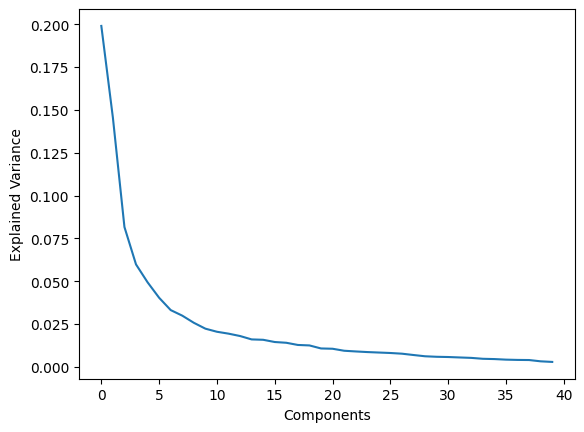

In [39]:
plot.plot(pca.explained_variance_ratio_)
plot.ylabel('Explained Variance')
plot.xlabel('Components')
plot.show()

LR - needs more looking into, might work using PCA to help with efficiency, overall horrible out the box

RF - Great performance out the box, doesn't need tuning and will most likely be efficient enough to not need PCA on full data set. 
Performs better than SVM, but can't use SVM due to not being probablistic. 

Because RF is pretty accurate without tuning on full dataset, we need to compare with other forms of data to see if there's a better probability return.

RF will probably be used to initially explore conference/team probability.
